# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration - Summary

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

# Choose Datasource: RAW (ppm) images vs PreProcessed Image Cache

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import gzip
import urllib
import zipfile
import glob
from PIL import Image
import csv
import matplotlib.image as mpimg
import pickle
import shutil

### Constants

In [2]:
DE_TRAFFIC_SIGNS_SOURCE_URL = "https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/"
GTSRB_SOURCE_URL = "http://benchmark.ini.rub.de/Dataset/"
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (32, 32, 3)
DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH) if DEFAULT_DEPTH > 1 else (DEFAULT_LENGTH, DEFAULT_WIDTH)

DEFAULT_IMG_EXTENSION = '.ppm'
DATASET_DIRECTORY = 'traffic-signs-data/'
DATACACHE_DIRECTORY = 'datacache/'
PRE_PROCESSED_ZIP = 'traffic-signs-data.zip'

TRAIN_IMAGES_ZIP = 'GTSRB_Final_Training_Images.zip'
TRAIN_IMAGES_DIR = 'GTSRB/Final_Training/Images'

TEST_IMAGES_ZIP = 'GTSRB_Final_Test_Images.zip'
TEST_IMAGES_DIR = 'GTSRB/Final_Test/Images'

TEST_LABELS_ZIP = 'GTSRB_Final_Test_GT.zip'
TESTING_LABELS_CSV = 'GT-final_test_annotated.csv'

### Helper Functions: Preprocessing Data: 

In [3]:
#Module for downloading and reading Datasets
def maybe_download(filename, work_directory, use_raw_dataset=True):
    filepath = os.path.join(work_directory, filename)
    if use_raw_dataset:
        SOURCE_URL = GTSRB_SOURCE_URL
    else:
        SOURCE_URL = DE_TRAFFIC_SIGNS_SOURCE_URL

    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
        filepath = os.path.join(work_directory, filename)
    if not os.path.exists(os.path.join(work_directory, filename)) or not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)

def unzip_file(source, destination):
    if not os.path.exists(destination):
        print('File does not exist: ', destination, ': Extracting')
        zipf = zipfile.ZipFile(source)
        print('Loaded zipf',zipf, ': Extracting')
        zipf.extractall(destination)
        zipf.close()

def read_csv(filepath, num_features = (8)):
    data_array = np.array([np.zeros(shape=num_features)])
    with open(filepath, newline='') as csvfile:
        annotations_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in annotations_reader:
            data_array = np.vstack((data_array, np.array(np.transpose(row[0].split(';')))))
    return data_array
            

def exclude_hidden_files(path):
    return glob.glob(os.path.join(path, '*'))

def resize_images(filepaths, with_labels=True):
    # Returns a list of images of corresponding filepaths
    images = []
    labels = [] if with_labels else None
    file_names = []

    for current_img in filepaths:
        if os.path.exists(current_img) and DEFAULT_IMG_EXTENSION in current_img:
            img = Image.open(current_img)
            if ((img.size) != (DEFAULT_LENGTH, DEFAULT_LENGTH)):
                print("IMAGE SIZE:",(img.size),"DEFAULT_SIZE:",(DEFAULT_LENGTH, DEFAULT_LENGTH))
                img = img.resize(DEFAULT_RESOLUTION[0:1], Image.ANTIALIAS)
            img.save(current_img)
            img.close()
            split_paths = current_img.split('/')

            if with_labels and split_paths[-2].isdigit():
                labels.extend([int(split_paths[-2])])
                file_names.extend(split_paths[-1])
            else:
                file_names.extend(str(current_img)) 
        else:
            print("File {0} is not an image with extension: {1}! Skipping..".format(
                  filepaths[i], DEFAULT_IMG_EXTENSION))
    if with_labels:
        return file_names, labels

def extract_training_data(filename, work_directory, images_path):
    #Unzip File
    unzip_file(filename, work_directory)
        
    #Walk Directories and load dataset
    images_path_dir = exclude_hidden_files(os.path.join(work_directory, images_path))
    label_array = []
    filename_array = []
    data = np.array([np.zeros(shape=DEFAULT_RESOLUTION)])
    for label_path in images_path_dir:
        working_dir= os.path.join(work_directory, images_path, label_path[-5:])
        if os.path.exists(working_dir):
            filenames = np.array([os.path.join(working_dir, path) for path
                           in os.listdir(working_dir) if DEFAULT_IMG_EXTENSION in path
                                  and ")" not in path and "(" not in path])         
            filenames_batch, labels_batch = resize_images(filenames)
            images_batch = np.array([mpimg.imread(os.path.join(working_dir, path)) for path
                                in os.listdir(working_dir) 
                                if DEFAULT_IMG_EXTENSION in path and
                                ")" not in path and "(" not in path], dtype=np.float32)
            if images_batch.shape[1:] == DEFAULT_RESOLUTION:
                data = np.vstack((data, images_batch))
            filename_array.extend(filenames_batch)
            label_array.extend(labels_batch)

    return (data[1:], label_array, filename_array)
        
def extract_testing_data(filename, work_directory, images_path):
    #Unzip File
    unzip_file(filename, os.path.join(work_directory, images_path))
    local_test_label_path = maybe_download(TEST_LABELS_ZIP, work_directory)
    
    unzip_file(local_test_label_path, work_directory)
    annotations = read_csv(os.path.join(work_directory, TEST_IMAGES_DIR, TESTING_LABELS_CSV))
    
    #Walk Directories and load Dataset
    images_path = exclude_hidden_files(os.path.join(work_directory, images_path))
    data = [np.array(np.zeros(shape=(32,32,3)))]
    filenames = np.array([path for path
                           in images_path if DEFAULT_IMG_EXTENSION in path
                                  and ")" not in path and "(" not in path and os.path.exists(path)])
    
    
    resize_images(filenames, with_labels=False)
    images_batch = np.array([mpimg.imread(path) for path
                        in images_path 
                        if DEFAULT_IMG_EXTENSION in path and
                        ")" not in path and "(" not in path], dtype=np.float32)
    labels_batch = np.array([int(label) for label in annotations[:,7] if np.chararray.isdigit(label)])    
    return (images_batch, labels_batch, annotations[:,0])

def extract_preprocessed_data(filename, work_directory):
    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
    datacache_directory = os.path.join(work_directory, DATACACHE_DIRECTORY)
    if not os.path.exists(datacache_directory):
        os.mkdir(datacache_directory)
#     filepath = os.path.join(work_directory, filename) 
    remove_from_path = len('/testing-data.zip')*-1 -6
    unzip_file(filename[:remove_from_path], datacache_directory)
    return datacache_directory

def restore_from_datacache(datacache_dir):
    training_file = os.path.join(datacache_dir,"train.p")
    testing_file = os.path.join(datacache_dir, "test.p") 
    
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    X_train, y_train = train['features'], train['labels']
    X_test, y_test = test['features'], test['labels']

    return (X_train, y_train, X_test, y_test)

def overwrite_datacache(training_set, testing_set, datacache_dir):
    if os.path.exists(datacache_dir):
        shutil.rmtree(datacache_dir, ignore_errors=True)
    os.mkdir(datacache_dir)
    
    training_file = os.path.join(datacache_dir,"train.p")
    testing_file = os.path.join(datacache_dir, "test.p") 
    
    train = { 'features': training_set.images, 'labels': training_set.labels }
    test = { 'features': testing_set.images, 'labels': testing_set.labels }

    pickle.dump(train, open(training_file, "wb"))
    pickle.dump(test, open(testing_file, "wb"))

    
def dense_to_one_hot(labels_dense, num_classes=43):
    #Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def extract_features(filename, one_hot=False):
    #Extract the labels into a 1D uint8 numpy array [index]."""
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
            'Invalid magic number %d in MNIST label file: %s' %
            (magic, filename))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    features = np.frombuffer(buf, dtype=np.uint8)
    if one_hot:
        return dense_to_one_hot(features)
    return labels

In [4]:
# class to store Datasets
class DataSet(object):
    def __init__(self, images, labels, filenames):
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)
        np_labels = np.array(labels)
        np_filenames = np.array(filenames)
        if np_filenames.shape[0] == 0:
            np_filenames = np.array(np.zeros_like(np_labels))
            
        self._num_examples = len(images)
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = images[perm]
        self._labels = np_labels[perm]   
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._filenames = np_filenames[perm]
        
    @property
    def images(self):
        return self._images
    @property
    def filenames(self):
        return self._filenames
    @property
    def labels(self):
        return self._labels
    @property
    def num_examples(self):
        return self._num_examples
    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    def next_batch(self, batch_size, with_label = False):
        #Return the next `batch_size` examples from this Dataset.
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            self._filenames = self._filenames[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        if with_label == True:
#             return self.distort_batch(self._images[start:end]), self._labels[start:end], self._filenames[start:end]
#         return self.distort_batch(self._images[start:end])
            return self._images[start:end], self._labels[start:end]
        return self._images[start:end]
    
    def distort_batch(self, batch):
        batch_size = len(batch)
        row_distort = np.random.randint(0, 3, batch_size)
        col_distort = np.random.randint(0, 3, batch_size)
        # dep_distort = np.random.randint(0, 3, batch_size)
        result = np.zeros(shape=(batch_size, DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH), dtype=np.float32)
        for i in range(batch_size):
            print("i", i)
            print("row_distort[i]:row_distort[i]+32 |", row_distort[i],row_distort[i]+32)
            print("col_distort[i]:col_distort[i]+32 |", row_distort[i],row_distort[i]+32)
            result[i, :, :, :] = batch[i, row_distort[i]:row_distort[i]+DEFAULT_LENGTH, col_distort[i]:col_distort[i]+DEFAULT_WIDTH, :]
        return result

    def show_example_images(self):        
        plot_images(self.images[-9:], self.labels[-9:])

    
    def shuffle_data(self):
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self._images[perm]
        self._labels = self._labels[perm]
        self._filenames = self._filenames[perm]
        
    def run_sanity_check(self):
        print("Sanity Check on Dataset ...", self)
        print("Images tensor shape:", self.images.shape)
        print("Labels vector length:",self.labels.shape)
        print("Number of image filenames vector length:",self.filenames.shape)
        print("Number of image examples in the set:",self.num_examples)
        print('')
        assert self.images.shape[0] == self.labels.shape[0], "The images/labels must match in the Dataset!\n"

    # Raw Dataset: 
    # "http://benchmark.ini.rub.de/Dataset/" (347 MB)
    
    # Pre-Processed (Classroom) Dataset: 
    # "https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip" (121 MB)
    def load_dataset(use_raw_dataset=True, refresh_datacache=False):
        working_dir = DATASET_DIRECTORY
        datacache_dir = os.path.join(working_dir, DATACACHE_DIRECTORY)    
            
        if use_raw_dataset:
            if  refresh_datacache:
                # Extract Training Data
                local_path = maybe_download(TRAIN_IMAGES_ZIP, working_dir, use_raw_dataset=True)
                train_images, train_labels, train_filenames = extract_training_data(local_path, working_dir, TRAIN_IMAGES_DIR)
                # Extract Testing Data
                local_path = maybe_download(TEST_IMAGES_ZIP, working_dir, use_raw_dataset=True)
                test_images, test_labels, test_filenames = extract_testing_data(local_path, working_dir, TEST_IMAGES_DIR)
                # Load Datasets
                training_set = DataSet(train_images, train_labels, train_filenames)
                testing_set = DataSet(test_images, test_labels, test_filenames) 
                # Overwrite Pickle File
                overwrite_datacache(training_set, testing_set, datacache_dir)
            else:
                # Extract Dataset from Pickle file
                train_images, train_labels, test_images, test_labels = restore_from_datacache(datacache_dir)
                train_filenames, test_filenames = (np.array([]), np.array([]))
                # Load Datasets
                training_set = DataSet(train_images, train_labels, train_filenames)
                testing_set = DataSet(test_images, test_labels, test_filenames)
        elif refresh_datacache:
            #Remove Datacache
            if os.path.exists(datacache_dir):
                shutil.rmtree(datacache_dir, ignore_errors=True)
                os.mkdir(datacache_dir)
            # Extract Preprocessed Data   
            local_path = maybe_download(PRE_PROCESSED_ZIP, working_dir, use_raw_dataset=False)
            datacache_dir = extract_preprocessed_data(local_path, working_dir)
            train_images, train_labels, test_images, test_labels = restore_from_datacache(datacache_dir)
            # Load Datasets
            training_set = DataSet(train_images, train_labels, train_filenames)
            testing_set = DataSet(test_images, test_labels, test_filenames)
            overwrite_datacache(training_set, testing_set, datacache_dir)
        else:
            # Extract Dataset from Pickle file
            train_images, train_labels, test_images, test_labels = restore_from_datacache(datacache_dir)
            train_filenames, test_filenames = (np.array([]), np.array([]))
            # Load Datasets
            training_set = DataSet(train_images, train_labels, train_filenames)
            testing_set = DataSet(test_images, test_labels, test_filenames)
            
        return (training_set, testing_set)


## Data Dimensions
The data dimensions are used in several places in the model below. They are defined once so we can use these variables instead of numbers throughout the code.

## Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

## Plot a few images to see if data is correct

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(DEFAULT_RESOLUTION))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### <font color='red'> Question 1</font> ###

_Describe the techniques used to preprocess the data._

** <font color='blue'> Answer: </font> **

In [6]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### <font color='red'> Question 2</font> ###

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

** <font color='blue'> Answer:</font> **

# Architecture

### Helper Class: <font color='green'> Batch Normalization</font>

In [7]:
class batch_norm(object):
    def __init__(self, batch_size, epsilon=1e-5, momentum = 0.1, name="batch_norm"):
        with tf.variable_scope(name) as scope:
            try:
                self.epsilon = epsilon
                self.momentum = momentum
                self.batch_size = batch_size

                self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
                self.name=name
            except ValueError:
                scope.reuse_variables()
                self.epsilon = tf.get_variable('epsilon')
                self.momentum = tf.get_variable('momentum')
                self.batch_size = tf.get_variable('batch_size')
                self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
                self.name = tf.get_variable('name')
            
            

    def __call__(self, x, train=True):
        shape = x.get_shape().as_list()

        with tf.variable_scope(self.name) as scope:
            try:
                self.gamma = tf.get_variable("gamma", [shape[-1]],
                            initializer=tf.random_normal_initializer(1., 0.02))
                self.beta = tf.get_variable("beta", [shape[-1]],
                            initializer=tf.constant_initializer(0.))
                self.mean, self.variance = tf.nn.moments(x, [0, 1, 2])
            except ValueError:
                scope.reuse_variables()
                self.gamma = tf.get_variable("gamma")
                self.beta = tf.get_variable("beta")
                self.mean, self.variance = tf.nn.moments(x, [0, 1, 2])

            return tf.nn.batch_norm_with_global_normalization(
                   x, self.mean, self.variance, self.beta, self.gamma, self.epsilon,
                   scale_after_normalization=True)

In [8]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
        
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):        
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear")as scope:
            try:
                matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                         tf.random_normal_initializer(stddev=stddev))
                bias = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(bias_start))
            except ValueError:  
                scope.reuse_variables()
                matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                         tf.random_normal_initializer(stddev=stddev))
                bias = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(bias_start))
        
    if with_w:
        return tf.matmul(input_, matrix) + bias, matrix, bias
    else:
        return tf.matmul(input_, matrix) + bias

def conv2d(input_, output_dim,
           filter_size=5, strides=2, stddev=0.02,
           name="conv2d"):
    with tf.variable_scope(name) as scope:
        try:
            w = tf.get_variable('w', [filter_size, filter_size, input_.get_shape()[-1], output_dim],
                        initializer=tf.truncated_normal_initializer(stddev=stddev))
        except ValueError:
            scope.reuse_variables()
            w = tf.get_variable('w', [filter_size, filter_size, input_.get_shape()[-1], output_dim],
                        initializer=tf.truncated_normal_initializer(stddev=stddev))
                
        conv = tf.nn.conv2d(input_, w, strides=[1, strides, strides, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        return conv

### Model

In [9]:
class Model():
    def __init__(self, batch_size=100, x_dim = DEFAULT_LENGTH, y_dim = DEFAULT_WIDTH, learning_rate= 0.0001, conv_depth = 32, num_classes=43):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.conv_depth = conv_depth

        # tf Graph batch of image (batch_size, height, width, depth)
        self.batch = tf.placeholder(tf.float32, [batch_size, x_dim, y_dim, DEFAULT_DEPTH], name="batch")
        self.batch_labels = tf.placeholder(tf.float32, [batch_size, self.num_classes], name="batch_labels") # dataset labels for the batch

        # batch normalization : deals with poor initialization helps gradient flow
        self.d_bn1 = batch_norm(batch_size, name='d_bn1')
        self.d_bn2 = batch_norm(batch_size, name='d_bn2')
        self.d_bn3 = batch_norm(batch_size, name='d_bn3')

        self.predict = self.discriminator(self.batch)
        self.cost = tf.reduce_mean(-tf.reduce_sum(self.batch_labels * tf.log(self.predict), reduction_indices=[1]))
        correct_prediction = tf.equal(tf.argmax(self.predict,1), tf.argmax(self.batch_labels,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)

        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        self.saver = tf.train.Saver(tf.all_variables())
        
    def flatten_layer(self, layer):
        # Get the shape of the input layer.
        layer_shape = layer.get_shape()

        # The shape of the input layer is assumed to be:
        # layer_shape == [num_images, img_height, img_width, num_channels]

        # The number of features is: img_height * img_width * num_channels
        # Function from TensorFlow is used to calculate this.
        num_features = layer_shape[1:4].num_elements()

        # Reshape the layer to [num_images, num_features].
        # Note that we just set the size of the second dimension
        # to num_features and the size of the first dimension to -1
        # which means the size in that dimension is calculated
        # so the total size of the tensor is unchanged from the reshaping.
        layer_flat = tf.reshape(layer, [-1, num_features])

        return layer_flat, num_features
        
    def discriminator(self, images):
        single_channel_size = DEFAULT_LENGTH*DEFAULT_WIDTH
        #Convert Feed Image into Linear Layer to give each pixel a weight        
        flattened_image, num_features = self.flatten_layer(images)
        print("flattened_image, num_features:",flattened_image, num_features)
        h_0 = linear(flattened_image, single_channel_size, 'd_h_0_linear')
        print("d_h_0_linear output:", h_0)
        
        #4 Convolution Layers
        h0 = lrelu(conv2d(tf.reshape(h_0, [-1, DEFAULT_LENGTH, DEFAULT_WIDTH, 1]), self.conv_depth, name='d_h0_conv'))
        print("d_h0_conv:", h0)
        h1 = lrelu(self.d_bn1(conv2d(h0, self.conv_depth*2, name='d_h1_conv')))
        print("d_h1_conv:", h1)
        h2 = lrelu(self.d_bn2(conv2d(h1, self.conv_depth*4, name='d_h2_conv')))
        print("d_h2_conv:", h2)
        h3 = lrelu(self.d_bn3(conv2d(h2, self.conv_depth*8, name='d_h3_conv')))
        print("d_h3_conv:", h3)
        
        #Feed Output of Conv into Fully-Connected Linear Layer to map to Num_Classes
        flattened_layer, num_features = self.flatten_layer(h3)
        print("flattened_layer, num_features:", flattened_layer, num_features)
        h4 = linear(flattened_layer, self.num_classes, 'd_h4_linear')
        print("d_h4_linear output:", h4,"\n")

        #Softmax to Normalize
        return tf.nn.softmax(h4)
    
    
    def to_one_hot(self, labels):
        # convert labels, a numpy list of labels (of size batch_size) to the one hot equivalent
        return np.eye(self.num_classes)[labels]
    
    def partial_train(self, batch, labels):
        _, cost, accuracy = self.sess.run((self.train_op, self.cost, self.accuracy),
                              feed_dict={self.batch: batch, self.batch_labels: self.to_one_hot(labels)})
        return cost, accuracy
    
#     def continue_optimizing(optimization_paramters):
#         if optimization_paramters: 
        
#         return should_optimize
    
#     def classify_validation_set(optimization_paramters):
#         #TODO: Finish validating
    

    def classify_test_set(self, testing_set, show_example_errors=True,
                            show_confusion_matrix=True):
        test_batch_size = 100

        # Allocate an array for the predicted classes which
        # will be calculated in batches and filled into this array.
        cls_pred = np.zeros(shape=testing_set.num_examples, dtype=np.int)
        testing_set.shuffle_data()
        total_batch = int(testing_set.num_examples / test_batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_images, batch_labels = testing_set.next_batch(test_batch_size, with_label = True)
            batch_labels = self.to_one_hot(batch_labels)

            # Get the correct batch of testing examples.
            batch_start = (i)*test_batch_size
            batch_end = min((i+1)*test_batch_size, testing_set.num_examples)

            # Create a feed-dict with these images and labels.
            feed_dict={self.batch: batch_images, self.batch_labels: batch_labels}

            # Calculate the predicted class using TensorFlow.
            cls_pred[batch_start:batch_end] = self.sess.run(tf.argmax(self.predict, dimension=1),
                                                            feed_dict=feed_dict)

        # Convenience variable for the true class-numbers of the test-set.
        cls_true_test = testing_set.labels

        # Create a boolean array whether each image is correctly classified.
        correct = (testing_set.labels == cls_pred)

        # Calculate the number of correctly classified images.
        correct_sum = correct.sum()

        # Classification accuracy is the number of correctly classified
        acc = float(correct_sum) / testing_set.num_examples

        # Print the accuracy.
        msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
        print(msg.format(acc, correct_sum, testing_set.num_examples))

        # Plot some examples of mis-classifications, if desired.
        if show_example_errors:
            print("Example errors:")
            plot_example_errors(cls_pred=cls_pred, correct=correct, testing_set=testing_set)

        # Plot the confusion matrix, if desired.
        if show_confusion_matrix:
            print("Confusion Matrix:")
            plot_confusion_matrix(cls_pred=cls_pred, testing_set=testing_set)
    
    def save_model(self, checkpoint_path, epoch):
        """ saves the model to a file """
        self.saver.save(self.sess, checkpoint_path, global_step = epoch)
        
    def close_session(self):
        self.sess.close()

    def load_model(self, checkpoint_path):
        ckpt = tf.train.get_checkpoint_state(checkpoint_path)
        print("loading model: ",ckpt.model_checkpoint_path)
        self.saver.restore(self.sess, ckpt.model_checkpoint_path)

** <font color='blue'> Answer:</font>**

# Session - Train/Optimize for Performance
Run the Tensorflow Graph to train model

### Helper-function: <font color='green'> Plot Example Errors</font> ###
Function for plotting examples of images from the test-set that have been mis-classified.

In [10]:
def plot_example_errors(cls_pred, correct, testing_set):
    # This function is called from classify_test_set() below.

    # cls_pred is an array of the predicted class-number for all images in the test-set.
    # correct is a boolean array whether the predicted class is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been incorrectly classified.
    images = testing_set.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true_test = testing_set.labels[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true_test[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function: <font color='green'> Plot Confusion Matrix</font> ###

In [11]:
def plot_confusion_matrix(cls_pred, testing_set):
    # This is called from classify_test_set() below.
    
    n_classes = testing_set.num_examples
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true_test = testing_set.labels
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true_test,
                          y_pred=cls_pred)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes, step=5)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.  
    plt.show()

### Helper-function: <font color='green'> Print Test Accuracy</font> ###

## Performance Measures
We need a few more performance measures to display the progress to the user.
This is a vector of booleans whether the predicted class equals the true class of each image.

### Helper-function: <font color='green'> Perform Optimization</font> ###
There are rougly 40,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

In [12]:
#Optimization Hyper Paramters
# Best validation accuracy seen so far.
best_validation_accuracy = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1000

optimization_hyperparameters = {"best_validation_accuracy": best_validation_accuracy,
                                "last_improvement": last_improvement,
                                "require_improvement": require_improvement}

In [22]:
def optimize(training_set, testing_set, num_epochs=5):
    # Start-time used for printing time-usage below.
    start_time = time.time()
    model = Model()
    
    batch_size = model.batch_size
    num_examples = training_set.num_examples
    training_epochs = num_epochs
    checkpoint_path = os.path.join(DATASET_DIRECTORY, DATACACHE_DIRECTORY, 'model.ckpt')

    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(DATACACHE_DIRECTORY)
    if ckpt:
        model.load_model(DATACACHE_DIRECTORY)
        
    # Training cycle
    for epoch in range(training_epochs):
        #if (model.continue_optimizing(optimization_hyperparameters)):
        avg_cost = 0.
        avg_accuracy = 0.
        training_set.shuffle_data()
        total_batch = int(num_examples / batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_images, batch_labels = training_set.next_batch(batch_size, with_label = True)
            #batch_images, batch_labels  = shuf_X_train[batch_start:batch_end], shuf_y_train[batch_start:batch_end]
            cost, accuracy = model.partial_train(batch_images, batch_labels)

            #assert( cost == cost and not math.isinf(cost)) # make sure it is not NaN or Inf
            #assert( accuracy == accuracy and not math.isinf(accuracy)) # make sure it is not NaN or Inf

            # Display logs per epoch step
            if (i % 100 == 0):
                print("epoch:", '%04d' % (epoch),
                      "batch:", '%04d' % (i), 
                      "cost=", "{:.6f}".format(cost),
                        "accuracy=", "{:.6f}".format(accuracy))

            # Compute average loss
            avg_cost += cost / num_examples * batch_size
            avg_accuracy += accuracy / num_examples * batch_size

        # Display logs per epoch step
        print("epoch:", '%04d' % (epoch), 
              "avg_cost=", "{:.6f}".format(avg_cost), 
              "avg_accuracy=", "{:.6f}".format(avg_accuracy))
            
    # save model every 1 epochs
    if epoch >= 0 and epoch % 1 == 0:
        model.save_model(checkpoint_path, epoch)
        print("model saved to {}".format(checkpoint_path))

    # save model one last time, under zero label to denote finish.
    model.save_model(checkpoint_path, 0)
    
    #Testing Cycle
    model.classify_test_set(testing_set=testing_set, show_confusion_matrix=False)
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    

### <font color='red'> Question 4</font> ###

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


** <font color='blue'> Answer:</font> **

### <font color='red'> Question 5</font> ###


_What approach did you take in coming up with a solution to this problem?_

** <font color='blue'> Answer:</font> **

### Helper-function: <font color='green'> Determine Performance</font> ###
Function for printing the classification accuracy on the test-set.
It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.
Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

### Performance before any optimization
The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

### Performance after 1 optimization iteration
The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [25]:
#Load Datasets
#training_set, testing_set = DataSet.load_dataset(use_raw_dataset=True, refresh_datacache=True) # Method 1
#training_set, testing_set = DataSet.load_dataset(refresh_datacache=True) #Overwrites Pickle file

training_set, testing_set = DataSet.load_dataset(use_raw_dataset=True, refresh_datacache=True)
training_set.run_sanity_check()
testing_set.run_sanity_check()

Sanity Check on Dataset ... <__main__.DataSet object at 0x116589860>
Images tensor shape: (39211, 32, 32, 3)
Labels vector length: (39211,)
Number of image filenames vector length: (39211,)
Number of image examples in the set: 39211

Sanity Check on Dataset ... <__main__.DataSet object at 0x112bc2128>
Images tensor shape: (12630, 32, 32, 3)
Labels vector length: (12630,)
Number of image filenames vector length: (12630,)
Number of image examples in the set: 12630



flattened_image, num_features: Tensor("Reshape_6:0", shape=(100, 3072), dtype=float32) 3072
d_h_0_linear output: Tensor("add_4:0", shape=(100, 1024), dtype=float32)
d_h0_conv: Tensor("lrelu_8/add:0", shape=(100, 16, 16, 32), dtype=float32)
d_h1_conv: Tensor("lrelu_9/add:0", shape=(100, 8, 8, 64), dtype=float32)
d_h2_conv: Tensor("lrelu_10/add:0", shape=(100, 4, 4, 128), dtype=float32)
d_h3_conv: Tensor("lrelu_11/add:0", shape=(100, 2, 2, 256), dtype=float32)
flattened_layer, num_features: Tensor("Reshape_8:0", shape=(100, 1024), dtype=float32) 1024
d_h4_linear output: Tensor("add_5:0", shape=(100, 43), dtype=float32) 

epoch: 0000 batch: 0000 cost= 3.821522 accuracy= 0.060000
epoch: 0000 batch: 0100 cost= 1.337825 accuracy= 0.650000
epoch: 0000 batch: 0200 cost= 0.825140 accuracy= 0.850000
epoch: 0000 batch: 0300 cost= 0.407669 accuracy= 0.930000
epoch: 0000 avg_cost= 1.157580 avg_accuracy= 0.714850
epoch: 0001 batch: 0000 cost= 0.454874 accuracy= 0.900000
epoch: 0001 batch: 0100 cost=

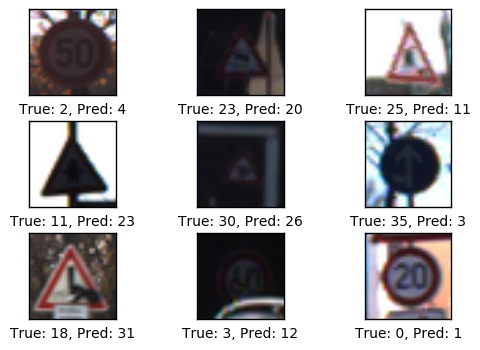

Time usage: 0:16:57


In [26]:
optimize(training_set=training_set, testing_set=testing_set)

---

# Step 3: Test a Model on <font color='red'> New</font> Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### <font color='red'> Question 6</font> ###

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



** <font color='blue'> Answer:</font> **

In [18]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### <font color='red'> Question 7</font> ###

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


** <font color='blue'> Answer:</font> **

In [19]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### <font color='red'> Question 8</font> ###

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


** <font color='blue'> Answer:</font> **

### <font color='red'> Question 9</font> ###

_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


** <font color='blue'> Answer:</font> **

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [20]:
model.close_session()

NameError: name 'model' is not defined